# 課題1

In [22]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def getKeyResponse(GazeDataFrame):
    tmp = GazeDataFrame[GazeDataFrame['Event'].isin(['KeyboardEvent'])]
    Response = tmp[1:16][tmp['Event value'] != 'space']['Event value'].values
    return Response

tmp = pd.read_table("./Class_EyeTracking/CorrectAnswer.csv")
Correct = tmp['Correct Answer'].values

ID_list = [f'ID{i:03d}' for i in range(20)] + [f'ID{i:03d}' for i in range(101, 106)]

result_dfs = []  # 各IDごとの結果を格納するためのリスト

# 000から019と101から105までのIDに対してループ
for i in ID_list:
    # csvファイルをロード
    df = pd.read_csv(f"./Class_EyeTracking/data/{i}_DataExport.csv")
    
    # getKeyResponse関数で 'Response' 列を生成
    Response = getKeyResponse(df)

    # Hit, False Alarm, Miss, Correct Rejectionの計算
    TP = sum((Response == 'Right') & (Correct == 'Right'))
    FP = sum((Response == 'Right') & (Correct == 'Left'))
    FN = sum((Response == 'Left') & (Correct == 'Right'))
    TN = sum((Response == 'Left') & (Correct == 'Left'))

    # 評価指標の計算
    Accuracy = (TP + TN) / (TP + FP + FN + TN)
    Precision = TP / (TP + FP)
    Recall = TP / (TP + FN)
    F = (2 * Precision * Recall) / (Precision + Recall)
    KeyMiss = 15 - TP - FP - FN - TN

    # 結果のDataFrameを作成
    result_df = pd.DataFrame({
        'ID': [i],
        'Accuracy': [Accuracy],
        'Precision': [Precision],
        'Recall': [Recall],
        "F-measure": [F],
        'TP': [TP],
        'FN': [FN],
        'FP': [FP],
        'TN': [TN],
        'KeyMiss': [KeyMiss]
    })

    # 結果をリストに追加
    result_dfs.append(result_df)

# 全ての結果を1つのDataFrameに結合
final_result_df = pd.concat(result_dfs, ignore_index=True)
final_result_df.to_csv("kadai1.csv", index=False)
# 結果のDataFrameを表示
final_result_df

,ID,Accuracy,Precision,Recall,F-measure,TP,FN,FP,TN,KeyMiss
0,ID000,1.000000,1.000000,1.000000,1.000000,10,0,0,4,1
1,ID001,0.866667,0.833333,1.000000,0.909091,10,0,2,3,0
2,ID002,0.600000,0.833333,0.500000,0.625000,5,5,1,4,0
3,ID003,0.666667,0.857143,0.600000,0.705882,6,4,1,4,0
4,ID004,0.866667,0.900000,0.900000,0.900000,9,1,1,4,0
5,ID005,0.933333,1.000000,0.900000,0.947368,9,1,0,5,0
6,ID006,0.600000,0.833333,0.500000,0.625000,5,5,1,4,0
7,ID007,1.000000,1.000000,1.000000,1.000000,10,0,0,5,0
8,ID008,0.800000,1.000000,0.700000,0.823529,7,3,0,5,0
9,ID009,0.800000,1.000000,0.700000,0.823529,7,3,0,5,0


# 課題2 TOI

In [62]:
import pandas as pd

ID_list = [f'ID{i:03d}' for i in range(20)] + [f'ID{i:03d}' for i in range(101, 106)]
stimuli_list = ['01_Kyoumu_T.png', '02_Amazon2_F.png', '03_Amazon3_F.png', '04_Rakuten2_F.png',
                '05_ticket_T.png', '06_Rakuten_F.png', '07_Rakuten_T.png', '08_yodobasi_F.png',
                '09_Apple1_F.png', '10_Kankou_T.png', '11_LINE_F.png', '12_Kyufu2_F.png',
                '13_ponta_T.png', '14_Kyufu_F.png', '15_SMBC_F.png']

# Create an empty dictionary to store results
result_data = {'ID': ID_list}

def getTOI(GazeDataFrame, MediaName):
    TOI = GazeDataFrame[GazeDataFrame['Presented Media name'].isin([MediaName])]
    return TOI

for MediaName in stimuli_list:
    durations = []
    for ID in ID_list:
        df = pd.read_csv(f"./Class_EyeTracking/data/{ID}_DataExport.csv")  # Experiment data path
        TOI = getTOI(df, MediaName)

        if not TOI.empty:
            TOI_start = TOI['Recording timestamp'].iloc[1]
            TOI_end = TOI['Recording timestamp'].iloc[-1]
            Duration = (TOI_end - TOI_start) / 1000000
            durations.append(Duration)
        else:
            durations.append(None)

    result_data[MediaName] = durations

# Convert the dictionary to a DataFrame
result_df = pd.DataFrame(result_data)

# 最大の秒数を持つIDと画像名を検索
max_duration_row = result_df.loc[result_df[result_df.columns[2:]].max(axis=1).idxmax()]

# 最小の秒数を持つIDと画像名を検索
min_duration_row = result_df.loc[result_df[result_df.columns[2:]].min(axis=1).idxmin()]

# 画像名を取得する際に None を除外
max_image_name = result_df.columns[2:][max_duration_row[result_df.columns[2:]].astype(float).values.argmax()] if not max_duration_row[result_df.columns[2:]].isna().all() else None
min_image_name = result_df.columns[2:][min_duration_row[result_df.columns[2:]].astype(float).values.argmin()] if not min_duration_row[result_df.columns[2:]].isna().all() else None

# 結果を出力
print("最大の秒数:")
print("ID:", max_duration_row['ID'])
print("画像名:", max_image_name)
print("秒数:", max_duration_row[result_df.columns[2:][max_duration_row[result_df.columns[2:]].astype(float).values.argmax()]])
print("\n最小の秒数:")
print("ID:", min_duration_row['ID'])
print("画像名:", min_image_name)
print("秒数:", min_duration_row[result_df.columns[2:][min_duration_row[result_df.columns[2:]].astype(float).values.argmin()]])

result_df


最大の秒数:
ID: ID015
画像名: 15_SMBC_F.png
秒数: 116.550561

最小の秒数:
ID: ID010
画像名: 08_yodobasi_F.png
秒数: 1.066667


,ID,01_Kyoumu_T.png,02_Amazon2_F.png,03_Amazon3_F.png,04_Rakuten2_F.png,05_ticket_T.png,06_Rakuten_F.png,07_Rakuten_T.png,08_yodobasi_F.png,09_Apple1_F.png,10_Kankou_T.png,11_LINE_F.png,12_Kyufu2_F.png,13_ponta_T.png,14_Kyufu_F.png,15_SMBC_F.png
0,ID000,6.633282,10.216574,5.583660,6.999929,5.533282,10.033595,9.116590,7.833262,7.433271,9.866582,6.616978,12.383224,10.050316,7.233343,9.383233
1,ID001,14.883203,7.849935,8.183259,7.483626,9.916563,10.300269,17.799830,16.366509,10.733593,11.399902,13.116915,13.383212,18.583225,13.500235,7.649920
2,ID002,9.799865,9.816524,2.699963,15.767044,6.933258,7.116640,13.883412,11.966543,13.916866,9.583249,10.283250,9.399913,11.849882,11.483384,11.433229
3,ID003,15.217012,30.716489,3.416631,19.949939,11.283942,2.716644,36.216285,9.900303,3.683504,14.766515,13.549879,7.516900,18.083485,16.116535,10.600275
4,ID004,40.016854,32.400183,22.400090,28.066825,56.366987,38.716875,41.033541,21.283443,24.150170,35.516866,12.150093,36.158540,35.458526,23.866802,31.933512
5,ID005,27.416806,24.300139,7.966655,13.850090,11.533411,23.083456,5.650042,7.533388,8.783370,15.166714,25.016791,35.916883,13.000047,24.383436,27.566795
6,ID006,23.466827,26.816824,11.633393,18.000101,25.750121,15.816777,19.816749,11.850069,5.400038,25.483450,4.566700,8.666740,9.350069,16.066770,11.050033
7,ID007,22.033461,4.300034,11.350059,21.083504,31.283526,31.883527,27.750163,6.316714,4.733369,36.750164,8.983410,21.200130,25.766856,12.433430,17.033474
8,ID008,23.650122,13.783415,15.183406,22.016829,19.466789,24.816808,24.483486,18.816803,14.266711,17.683428,9.850070,20.116804,22.083462,10.866705,21.816829
9,ID009,6.300018,4.066684,7.250046,11.866707,9.250039,11.900043,27.483446,14.166705,14.416714,19.716726,6.550021,27.916777,18.316733,16.233385,9.433382


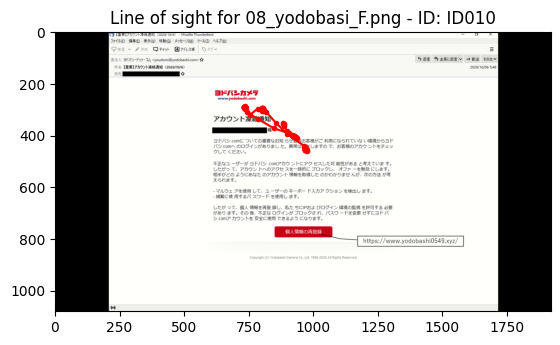

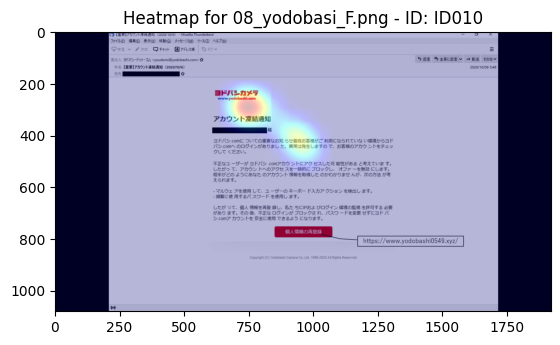

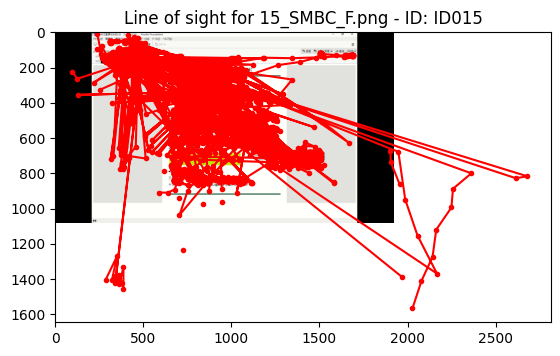

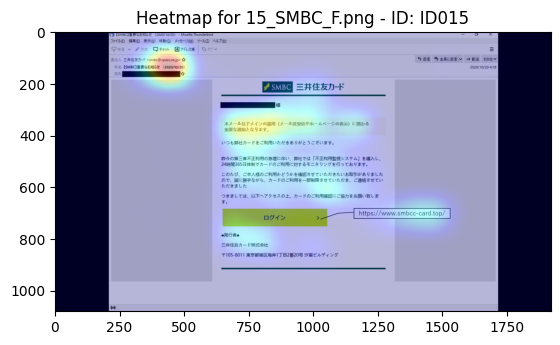

<Figure size 640x480 with 0 Axes>

In [3]:
# ライブラリインポート
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np

ID_list = [f'ID{i:03d}' for i in range(20)] + [f'ID{i:03d}' for i in range(101, 106)]
stimuli_list = ['01_Kyoumu_T.png', '02_Amazon2_F.png', '03_Amazon3_F.png', '04_Rakuten2_F.png',
                '05_ticket_T.png', '06_Rakuten_F.png', '07_Rakuten_T.png', '08_yodobasi_F.png',
                '09_Apple1_F.png', '10_Kankou_T.png', '11_LINE_F.png', '12_Kyufu2_F.png',
                '13_ponta_T.png', '14_Kyufu_F.png', '15_SMBC_F.png']

# Create an empty dictionary to store results
result_data = {'ID': ID_list}

def getTOI(GazeDataFrame, MediaName):
    TOI = GazeDataFrame[GazeDataFrame['Presented Media name'].isin([MediaName])]
    return TOI

for MediaName in stimuli_list:
    durations = []
    for ID in ID_list:
        df = pd.read_csv(f"./Class_EyeTracking/data/{ID}_DataExport.csv")  # Experiment data path
        TOI = getTOI(df, MediaName)

        if not TOI.empty:
            TOI_start = TOI['Recording timestamp'].iloc[1]
            TOI_end = TOI['Recording timestamp'].iloc[-1]
            Duration = (TOI_end - TOI_start) / 1000000
            durations.append(Duration)
        else:
            durations.append(None)

    result_data[MediaName] = durations

# Convert the dictionary to a DataFrame
result_df = pd.DataFrame(result_data)

# 最大の秒数を持つIDと画像名を検索
max_duration_row = result_df.loc[result_df[result_df.columns[2:]].max(axis=1).idxmax()]

# 最小の秒数を持つIDと画像名を検索
min_duration_row = result_df.loc[result_df[result_df.columns[2:]].min(axis=1).idxmin()]

# 画像名を取得する際に None を除外
max_image_name = result_df.columns[2:][max_duration_row[result_df.columns[2:]].astype(float).values.argmax()] if not max_duration_row[result_df.columns[2:]].isna().all() else None
min_image_name = result_df.columns[2:][min_duration_row[result_df.columns[2:]].astype(float).values.argmin()] if not min_duration_row[result_df.columns[2:]].isna().all() else None

duration_list = ['min', 'max']

for duration_type in duration_list:
    #----- 被験者応答読み込み
    ID = max_duration_row['ID'] if duration_type == 'max' else min_duration_row['ID']

    # csvファイルをロード
    df = pd.read_csv("./Class_EyeTracking/data/" + ID + "_DataExport.csv") #実験データへのパス

    # TOI抽出
    MediaName = max_image_name if duration_type == 'max' else min_image_name
    TOI = getTOI(df, MediaName)

    # 視線位置の X, Y を取得。この値を使ってプロットする。
    GazeX = TOI['Gaze point X']
    GazeY = TOI['Gaze point Y']

    # 刺激画像の読み込み;
    img_bgr = cv2.imread('./Class_EyeTracking/stimuli/' + MediaName[:-4] + '_Stim.png')
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)


    # 画像の表示
    plt.imshow(img)
    plt.plot(GazeX, GazeY, 'r.-')
    # タイトルを追加
    plt.title("Line of sight for {} - ID: {}".format(MediaName, ID))
    plt.show()

    # 1. ----- 画像配列初期化
    imSize = img.shape
    heatmap = np.zeros([imSize[0], imSize[1]], dtype='float32')

    # イメージのサイズを取得
    image_height, image_width = imSize[:2]

    # 2.～4. ----- 視線位置が記録された画素をインクリメント
    for i in range(len(GazeX)):
        # 視線位置が記録されていれば処理（Eyes Not Found の場合もあるので。）
        if not (np.isnan(GazeX.iloc[i]) or np.isnan(GazeY.iloc[i])):
            # インデックスが画像サイズを超えないように制約
            xx = min(int(GazeX.iloc[i]), image_width - 1)
            yy = min(int(GazeY.iloc[i]), image_height - 1)
            heatmap[yy, xx] = heatmap[yy, xx] + 1

    # 5. ----- ぼかしを適用
    # 標準偏差=50pixのガウス分布を使用
    # ガウス分布が0に漸近するのに十分なカーネルサイズを指定; 標準偏差の4倍あればOK
    heatmap_blur = cv2.GaussianBlur(heatmap, (201,201), 50)
    # 画像を 0-1 に正規化
    MAX = np.max(heatmap_blur)  # 最大値
    MIN = np.min(heatmap_blur)  # 最小値
    heatmap_blur = (heatmap_blur - MIN)/(MAX - MIN) # 正規化

    #----- 表示するための作業
    # ヒートマップをRGBに変換
    heatmap_rgb = np.uint8(255 * heatmap_blur)
    # JETのカラーマップを適用
    heatmap_rgb = cv2.applyColorMap(heatmap_rgb, cv2.COLORMAP_JET)
    # RGBに変換
    heatmap_rgb = cv2.cvtColor(heatmap_rgb, cv2.COLOR_BGR2RGB)

    superimposed_img = heatmap_rgb*0.4 + img
    superimposed_img = superimposed_img/np.max(superimposed_img)

    # 画像を表示
    fig = plt.figure()
    # タイトルを追加
    plt.title("Heatmap for {} - ID: {}".format(MediaName, ID))
    plt.imshow(superimposed_img)

    # 保存
    filename = 'heatmap_' + MediaName
    plt.savefig(filename[:-4] + '.svg')
    plt.savefig(filename)
    plt.figure()



# 課題3 AOI

In [5]:
# 課題3：被験者1名のAOI時間を、画像刺激間で平均する。
import pandas as pd
import numpy as np

ID = 'ID000'
raw = pd.read_table('./Class_EyeTracking/Metrics/' + ID + '_Metrics.tsv')

cutLabels = []  # 抽出するデータラベルを保存するリスト
for label in raw.columns:
    # if文で特定の文字列を含む列を抽出
    if label.find('Total_duration_of_fixations') \
        != -1 or label.find('Duration_of_interval') \
            != -1 or label.find('TOI') != -1:
        cutLabels.append(label)  # リストに追加

# データを抽出
df = raw[cutLabels]

NUM = 15  # 呈示刺激の数; 今回は 15なので 15+1=16
TOI = raw['TOI'].iloc[0:NUM]  # TOIを初期化; rawデータから引っ張ってくる
res = np.zeros([NUM, 4])

# 'Total_duration_of_fixations'が含まれる列を抽出
total_fixations_columns = [col for col in df.columns \
                           if 'Total_duration_of_fixations' in col]

# 各列の合計を計算
total_fixations = df[total_fixations_columns].sum(axis=1)


# TOIでloop 処理
for i in range(NUM):
    # 計算用変数の初期化
    Header = 0
    HeaderTime = 0
    Footer = 0
    URL = 0

    tmp = df[i:i + 1].dropna(how="all", axis=1)  # 欠損値（NaN）を含むデータラベルを除外
    #TOTAL = np.array(total_fixations.iloc[i])  # 'Total_duration_of_fixations'列の値をTOTALに変更
    TOTAL = np.array(tmp['Duration_of_interval'].values)

    # データラベルで loop 処理
    for label in tmp.columns:
        # データラベルが Header で終わる列を抽出
        if label.endswith('Header') == 1:
            Header += tmp[label].values
        # データラベルが HeaderTime で終わる列を抽出
        if label.endswith('HeaderTime') == 1:
            HeaderTime += tmp[label].values
        # データラベルが Footer で終わる列を抽出
        if label.endswith('Footer'):
            Footer += tmp[label].values
        # データラベルに URL を含む列を抽出
        if label.find('URL') != -1:
            URL += tmp[label].values

    # 結果を格納
    Header = np.array(Header)
    HeaderTime = np.array(HeaderTime)
    Footer = np.array(Footer)
    URL = np.array(URL)

    # 各変数を正規化してから結合
    calc = np.column_stack([Header, HeaderTime, Footer, URL]) / TOTAL[:, np.newaxis]
    res[i, :] = calc[0]

# DataFrame として統合
df_sum = pd.DataFrame(res,
                      columns=['Header', 'HeaderTime', 'Footer', 'URL'],
                      index=TOI)
df_sum.to_csv(f"kadai3{ID}.csv", index=False)
df_sum


,Header,HeaderTime,Footer,URL
TOI,,,,
01_Kyoumu_T,0.162857,0.025113,0.162857,0.149173
02_Amazon2_F,0.196228,0.064693,0.000000,0.012215
03_Amazon3_F,0.449464,0.187500,0.000000,0.136964
04_Rakuten2_F,0.143651,0.091492,0.000000,0.017814
05_ticket_T,0.111171,0.135135,0.000000,0.057117
06_Rakuten_F,0.143483,0.062189,0.000000,0.149254
07_Rakuten_T,0.115844,0.135005,0.000000,0.023760
08_yodobasi_F,0.190064,0.171975,0.000000,0.021274
09_Apple_F,0.097315,0.135839,0.000000,0.027919
